<center>
<h1>
<h1>APM 53674: ALTeGraD</h1>
<h2>Lab Session 3: Improving LLMs with RLHF (DPO & GRPO)</h2>
<h4>Lecture: Prof. Michalis Vazirgiannis<br>
Lab: Yang Zhang and Xiao Fei</h4>
<h5>Tuesday, October 14, 2025</h5>
<br>
</center>

<hr style="border:10px solid gray"> </hr>
<p style="text-align: justify;">
This handout includes theoretical introductions, <font color='blue'>coding tasks</font> and <font color='red'>questions</font>. Before the deadline, you should submit <a href='https://forms.gle/9dyaes6dimfvyjwq6' target="_blank">here</a> a <B>.ipynb</B> file named <b>Lastname_Firstname.ipynb</b> containing your notebook (with the gaps filled and your answers to the questions). Your answers should be well constructed and well justified. They should not repeat the question or generalities in the handout. When relevant, you are welcome to include figures, equations and tables derived from your own computations, theoretical proofs or qualitative explanations. One submission is required for each student. The deadline for this lab is <b>October 19
, 2025 11:59 PM</b>. No extension will be granted. Late policy is as follows: ]0, 24] hours late → -5 pts; ]24, 48] hours late → -10 pts; > 48 hours late → not graded (zero).
</p>
<hr style="border:5px solid gray"> </hr>


# 🤖 Post-Training: Improving LLMs with RLHF (DPO & GRPO)

In this notebook, we’ll show how to improve a language model using **two post-training techniques**:

### 🧠 What You’ll Learn
- What **Direct Preference Optimization (DPO)** is and how it helps models choose better answers.
- What **Group Relative Policy Optimization (GRPO)** is and how it helps models solve tasks  improving reasoning and performance on complex tasks (math, code, logic).
- How to train small models on **real feedback data**.
- How to **observe changes in model behavior** after fine-tuning.


### 📦 What We’ll Use
- **Hugging Face 🤗 Transformers** to load and run models
- **TRL (Transformer Reinforcement Learning)** library by Hugging Face 🤗 for DPO and GRPO
- **A small version** of the French translated [Anthropic HH-RLHF dataset](https://huggingface.co/datasets/AIffl/french_hh_rlhf)
- **Colab GPU**, so models are small enough to run quickly

### Useful links:
- [Hugging Face 🤗 DPO Trainer](https://huggingface.co/docs/trl/dpo_trainer)
- [Hugging Face 🤗 GRPO Trainer](https://huggingface.co/docs/trl/grpo_trainer)

> This notebook is interactive, friendly, and high-level. You don’t need to know deep math or theory to follow along.

# Quick start:
1-  Clone the repository:
```bash
git clone https://github.com/BounharAbdelaziz/RLHF.git
```
2- Install the dependencies:
```bash
pip install -q -r requirements.txt
```
Now we are ready to go!

In [1]:
!pwd

/content


In [2]:
!git clone https://github.com/BounharAbdelaziz/RLHF.git

Cloning into 'RLHF'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 15 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 13.46 KiB | 3.36 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [5]:
!pip install -q -r RLHF/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 13.9 MB/s eta 0:00:00


# Part I: DPO

# 🧠 Fine-tuning Qwen2.5-0.5B-Instruct on French Data

In this part, we’ll walk through how to **fine-tune the Qwen2.5-0.5B-Instruct** model on **French-language data**, using **off-policy DPO (Direct Preference Optimization)**.

---

## 🧩 Key Concepts

- **Model**: [Qwen2.5-0.5B-Instruct](https://huggingface.co/Qwen/Qwen2.5-0.5B-Instruct)  
- **Objective**: Adapt the model for French understanding and instruction-following  
- **Method**: Off-policy **DPO** for alignment-based fine-tuning  

---

## ⚙️ System Requirements

Before training, make sure you choose an appropriate GPU setup.

- **Memory requirements**: [GPU memory guidance](https://rahulschand.github.io/gpu_poor/)  
- **GPU options**:
  - AWS SageMaker: [pricing calculator](https://aws.amazon.com/sagemaker-ai/pricing/)  
  - 💸 Cheaper alternative: [RunPod](https://www.runpod.io/)  

---

## 🧮 Memory Optimization

We’ll use **LoRA** (Low-Rank Adaptation) combined with **quantization (4-bit)** to reduce GPU memory usage while maintaining performance.

---

## 🧪 Evaluation Tools

To evaluate the fine-tuned model, you can use one or more of the following frameworks:

- [`lm-eval-harness`](https://github.com/EleutherAI/lm-evaluation-harness)
- [`lighteval`](https://github.com/huggingface/evaluate)
- [`libra-eval`](https://github.com/facebookresearch/libra)

---
Below is a visual overview of the **Direct Preference Optimization (DPO)** training process:

![DPO Training Diagram](https://1drv.ms/i/c/ae69638675180117/IQQ_wS77RKdrS4tzLbwoqr1gAR0Bf_1X2U36NRBp1Odsypg?width=560&height=48)

In [6]:
# Imports
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
)
from trl import (
    DPOTrainer,
    DPOConfig,
)
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
)
import torch
import os
import wandb

## 📊 Tracking with Weights & Biases (W&B)

We’ll use **Weights & Biases (W&B)** to log training metrics, model versions, and system stats so you can compare runs, debug faster, and share results. Before running the next cell, **create a free account** at [https://wandb.ai](https://wandb.ai) and make a new **Project** (e.g., `RLHF`). In the code cell that follows, we’ll initialize W&B; on first use you’ll need to **register** then paste your **API key** from your W&B profile. During training, W&B will automatically track losses, learning rate, gradient norms, and GPU utilization, and we’ll log custom metrics (e.g., validation perplexity, evaluation scores) plus configuration details (dataset, hyperparameters, LoRA/quantization settings). Each run will appear on your project dashboard with charts, tables, run metadata, and artifacts, making it easy to **compare experiments**, **resume runs**, and **share dashboards** with your teammates.


<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 1: </b><br>
Create your Weights&Biases account and fill the gap the next cell.
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [ ]:
# We will use wandb.ai for logging the experiments - Set your API key here
WANDB_API_KEY = "069d8fb8aa3c1fe8653fc433ad8c0c7fd672dde5" # fill the gap with your wandb account

# Automatically login using the API key
os.environ["WANDB_API_KEY"] = WANDB_API_KEY
os.environ["WANDB_PROJECT"] = "RLHF"
wandb.login()

# Training dataset
DATASET_PATH = "AIffl/french_orca_dpo_pairs" # french version of "Intel/orca_dpo_pairs"

# We limit to 2k samples for speed
LIMIT = 2_000

# SFT Model we will finetune
MODEL_NAME = "Qwen/Qwen2.5-0.5B-Instruct"
# Seed for reproducibility
SEED = 1998

MAX_PROMPT_LEN = 1024
MAX_LENGTH = MAX_PROMPT_LEN + 512

RUN_NAME = "DPO-french-orca-" + MODEL_NAME.split('/')[-1]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: vujadinovicn to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Load the SFT Model and Tokenizer

We’ll stick with 4-bit quantization via bitsandbytes for this lab. You’ve already used it last week, so nothing new—same setup (load the model with 4-bit weights), same goal (reduce VRAM) with minimal impact on quality for our use case. This keeps runs feasible on a single GPU.

We will need the tonkenizer in the data preparation step to apply the chat template.

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 2: </b><br>
Create the quantization confiduration to load the model with 4 bits
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [ ]:
# Quantization configuration
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
) #fill the gap

# Load the model to finetune
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    quantization_config=quantization_config,
    device_map="auto",
    trust_remote_code=True,
)
# to avoid warning
model.config.use_cache = False
# Prepare model for k-bit training
model = prepare_model_for_kbit_training(model)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

# Set padding token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

## Data Preparation

### 💬 Chat templates & converting data to `messages`

Modern instruction-tuned models (including **Qwen2.5-0.5B-Instruct**) expect inputs in a **chat format** and rely on a **tokenizer chat template** to turn structured messages into the exact token sequence the model was trained on. In practice, you should **not** hand-craft special tokens; instead, pass a list of `{role, content}` messages to the tokenizer and let `apply_chat_template(...)` do the right thing.

#### Why a chat template?
- Ensures your prompts match the **pretraining/finetuning format** (system/user/assistant turns, BOS/EOS, separators).
- Minimizes prompt drift across libraries and models.
- Makes it easy to add **system instructions** (e.g., “You are a helpful assistant that answers in French.”).

#### Message structure
Each example becomes an ordered list of chat turns:
```python
messages = [
  {"role": "system", "content": "Tu es un assistant utile. Réponds en français."},
  {"role": "user", "content": "Explique la différence entre LoRA et le fine-tuning complet."},
  {"role": "assistant", "content": "LoRA adapte un petit sous-espace de poids, alors que..."}
]


<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 3: </b><br>
Create the user message which is the question field of the dataset.
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [ ]:
def preprocess_for_dpo(example):
    # Format system message if present
    messages = []
    if example.get('system') and len(example['system'].strip()) > 0:
        messages.append({"role": "system", "content": example['system']})

    # fill the gap, add user message from the question filed of th
    user_message = {"role": "user", "content": example['question']} # fill here
    messages.append(user_message)

    # Create prompt with generation prompt for DPO
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    # The chosen and rejected should be the assistant responses only
    chosen = example['chosen']
    rejected = example['rejected']

    return {
        "prompt": prompt,
        "chosen": chosen,
        "rejected": rejected,
    }

# Download the training dataset
dataset = load_dataset(DATASET_PATH, split=f"train")
# shuffle and select a number of samples
dataset = dataset.shuffle(True).select(range(LIMIT))

# Save columns
original_columns = dataset.column_names

# Apply the preprocessing function
dpo_dataset = dataset.map(
    preprocess_for_dpo,
    remove_columns=original_columns,
)

# Filter out examples that are too long
def filter_length(example):
    prompt_length = len(tokenizer.encode(example['prompt']))
    chosen_length = len(tokenizer.encode(example['chosen']))
    rejected_length = len(tokenizer.encode(example['rejected']))

    return (prompt_length + max(chosen_length, rejected_length)) < MAX_LENGTH

dpo_dataset = dpo_dataset.filter(filter_length)

print(f"Dataset size after filtering: {len(dpo_dataset)}")

README.md:   0%|          | 0.00/468 [00:00<?, ?B/s]

french_orca_rlhf.jsonl:   0%|          | 0.00/45.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12670 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset size after filtering: 1954


## Model Training

Training will mirror last week’s lab, but we’ll switch from SFT to **off-policy DPO** using the `trl` library. Concretely, we’ll instantiate a **policy model** (trainable) and a **reference model** (frozen) and optimize with the DPO objective so the policy prefers **chosen** over **rejected** responses for the same prompt.

### What we’ll use
- **TRL**: `DPOConfig`, `DPOTrainer`
- **PEFT**: LoRA adapters on top of the base **Qwen2.5-0.5B-Instruct**
- **Quantization**: 4-bit (QLoRA-style) to fit on small GPUs
- **Logging**: W&B for metrics, configs, and artifacts

### Expected dataset columns
- `prompt` (or `messages`): the shared context (system+user turns)
- `chosen`: assistant reply preferred by annotators
- `rejected`: less-preferred reply
> If you’re keeping everything in chat format, we’ll pass lists of `{role, content}` and rely on `tokenizer.apply_chat_template(...)` inside the collator.

### Minimal training flow
1. Load tokenizer with the **chat template** and enable 4-bit loading of the base model.
2. Wrap the model with **LoRA** (target attention/MLP modules).
3. Build a `datasets.Dataset` that yields `(prompt/messages, chosen, rejected)`.
4. Define `DPOConfig` (batch size, lr, epochs, `beta`, logging/saving/eval cadence).
5. Create `DPOTrainer(policy_model, ref_model, tokenizer, train_dataset, eval_dataset, **config)`.
6. Call `trainer.train()`; optional `trainer.evaluate()` and `trainer.save_model()`.


<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 4: </b><br>
Create the lora config with rank of 32, alpha of 64 and dropout of 0.1 on all MLP layers (execluding Embedding layers) and train the model
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [ ]:
# LoRA configuration - targeting the correct modules for Qwen2.5
peft_config = LoraConfig(
    r = 32,
    lora_alpha = 64,
    target_modules = [
      "q_proj", "k_proj", "v_proj", "o_proj",   # attention projections
      "gate_proj", "up_proj", "down_proj"       # MLP projections; no embedding layers or heads
    ],
    lora_dropout = 0.1,
    bias = "none",
    task_type = "CAUSAL_LM"
) # fill the gap

# Apply LoRA to the model
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# Training configuration
training_args = DPOConfig(
    beta=0.1,  # DPO temperature parameter
    learning_rate=5e-6,
    max_prompt_length=MAX_PROMPT_LEN,
    max_length=MAX_LENGTH,
    per_device_train_batch_size=1,  # Reduced for memory
    gradient_accumulation_steps=4,  # Increased to maintain effective batch size of 4 (1*4)
    num_train_epochs=1,
    max_grad_norm=1.0,
    logging_steps=1,
    save_steps=100,
    lr_scheduler_type="cosine",
    optim="paged_adamw_8bit",  # More memory efficient
    warmup_ratio=0.03, # 3% of the steps will be just a warmup
    save_strategy="steps",
    output_dir="./dpo_model",
    report_to="wandb",
    run_name=RUN_NAME,
    remove_unused_columns=False,
    dataloader_pin_memory=False,
    fp16=True,  # Enable mixed precision
)

# Initialize the trainer - Note: no ref_model needed when using peft_config
trainer = DPOTrainer(
    model=model,
    args=training_args,
    peft_config=peft_config,  # This automatically handles reference model
    processing_class=tokenizer,
    train_dataset=dpo_dataset,
)

# Print a sample to verify preprocessing
print("Sample from dataset:")
print(f"Prompt: {dpo_dataset[0]['prompt']}")
print(f"Chosen: {dpo_dataset[0]['chosen']}")
print(f"Rejected: {dpo_dataset[0]['rejected']}")

# Train
trainer.train()

trainable params: 17,596,416 || all params: 511,629,184 || trainable%: 3.4393


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:348: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Extracting prompt in train dataset:   0%|          | 0/1954 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1954 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1954 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Sample from dataset:
Prompt: <|im_start|>system
Vous êtes un assistant utile, qui fournit toujours des explications. Pensez comme si vous répondiez à un enfant de cinq ans.<|im_end|>
<|im_start|>user
Prémisse:
"pour les drogues, ils appliquent la peine de mort pour ça, euh, ils sont juste très très durs et je suppose que c'est peut-être comme ça à Tokyo ou au Japon aussi, ils sont juste très durs avec les criminels" Basée sur cette prémisse, c'est l'hypothèse "Pour les drogues, ils appliquent la peine de mort, mais ils sont très très durs envers les criminels et c'est peut-être la même chose à Tokyo ou au Japon." vrai?
Choisissez votre réponse parmi :
[1]. Oui;
[2]. il n'est pas possible de le savoir ;
[3]. Non;<|im_end|>
<|im_start|>assistant

Chosen: [1]. Oui
Rejected: Ohh ! Laissez-moi y réfléchir comme un assistant super sympa et intelligent ! 🤔

Donc, vous dites que certains endroits, comme Tokyo ou le Japon, sont très durs envers les gens qui font de mauvaises choses, comme la dr

wandb: Detected [huggingface_hub.inference, openai] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


RuntimeError: All input tensors need to be on the same GPU, but found some tensors to not be on a GPU:
 [(torch.Size([32, 896]), device(type='cpu')), (torch.Size([32, 896]), device(type='cpu')), (torch.Size([32, 896]), device(type='cpu')), (torch.Size([32, 896]), device(type='cpu')), (torch.Size([256]), device(type='cpu')), (torch.Size([256]), device(type='cpu')), (torch.Size([112]), device(type='cpu')), (torch.Size([112]), device(type='cpu'))]

In [ ]:
# merge LoRA adapters with the base model
save_path = "dpo_model/final_merged_dpo_model"

model = model.merge_and_unload()
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

## Model Testing

We will test the DPO model via chat-app
To validate alignment gains, we’ll spin up a small **Gradio** app that queries both the **pre-DPO** model (baseline/reference) and the **post-DPO** **policy** side-by-side. The UI lets you enter a French prompt, then compares generations using the **same chat template** and decoding settings. This helps spot qualitative shifts in helpfulness, safety, and instruction-following.

In [ ]:
from RLHF.chat_app import launch_chat_app

launch_chat_app(
    model_path=save_path, #"habdine/CSC_53432_lab3_dpo",
    base_model_path="Qwen/Qwen2.5-0.5B-Instruct",
    title="🤖 Dual-Model Qwen Chat (DPO vs Base) for French",
    DPO_TEST=True,
    FRENCH_TEST=True,
)

In [ ]:
from RLHF.chat_app import launch_chat_app

launch_chat_app(
    model_path="BounharAbdelaziz/Qwen2.5-0.5B-DPO-English-Orca",
    base_model_path="Qwen/Qwen2.5-0.5B-Instruct",
    title="🤖 Dual-Model Qwen Chat (DPO vs Base) for English",
    DPO_TEST=True,
    FRENCH_TEST=False,
)

🔄 Loading DPO Model from: BounharAbdelaziz/Qwen2.5-0.5B-DPO-English-Orca


config.json:   0%|          | 0.00/683 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

✅ DPO Model loaded successfully!
🔄 Loading Base Model from: Qwen/Qwen2.5-0.5B-Instruct
✅ Base Model loaded successfully!


/content/RLHF/chat_app.py:174: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot_dpo_ui = gr.Chatbot(
/content/RLHF/chat_app.py:190: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot_base_ui = gr.Chatbot(


🚀 Launching Dual-Model Gradio Chat Interface…
🟢 Finetuned model: BounharAbdelaziz/Qwen2.5-0.5B-DPO-English-Orca
🔵 Base model: Qwen/Qwen2.5-0.5B-Instruct
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://04f90777992d2479cf.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Part II: GRPO


The following diagram illustrates the **GRPO (Generative Reinforcement Preference Optimization)** process — an alternative to DPO that directly optimizes generation quality from preference data using reinforcement-style updates:

![GRPO Training Overview](https://1drv.ms/i/c/ae69638675180117/IQQ-KizPdUxCRZU9qDGcpX1AAeettH1uhsJqqM1WjXiYR6s?width=705&height=66)

After exploring DPO, we now move on to **GRPO** — a reinforcement learning–style approach that builds directly on preference data.  
While **DPO** adjusts the model using an *analytic loss* derived from preference pairs, **GRPO** takes a more dynamic route: it uses **reward modeling and policy gradients** to optimize the model through sampled generations.

In essence:
- GRPO **learns from human (or model) preferences** using *on-policy* updates.  
- It combines elements of **PPO** (Proximal Policy Optimization) with **preference-based rewards** rather than explicit numerical scores.  
- This allows the model to better capture *generation quality* aspects that aren’t directly expressible through static loss terms.

In the next section, we’ll explore how to configure and launch a **GRPO training loop** using `trl`, reusing much of our previous setup (tokenizer, LoRA, quantization) but switching to **on-policy optimization**.

In [7]:
import torch
import re
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
)
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    prepare_model_for_kbit_training,
)
from trl import (
    GRPOConfig,
    GRPOTrainer,
)
import os
import wandb

# We will use wandb.ai for logging the experiments - Set your API key here
WANDB_API_KEY = "069d8fb8aa3c1fe8653fc433ad8c0c7fd672dde5" # fill the gap with your wandb key

# Automatically login using the API key
os.environ["WANDB_API_KEY"] = WANDB_API_KEY
os.environ["WANDB_PROJECT"] = "RLHF"
wandb.login()

# Training dataset
DATASET_PATH = "openai/gsm8k"

# We limit to 200 samples for speed
LIMIT = 200

# SFT Model we will finetune
MODEL_NAME = "Qwen/Qwen2.5-0.5B-Instruct"
# MODEL_NAME = "Qwen/Qwen2.5-3B-Instruct"
# Seed for reproducibility
SEED = 1998

USE_LORA = True

if MODEL_NAME == "Qwen/Qwen2.5-0.5B-Instruct":
  USE_QUANT = False
else:
  USE_QUANT = True

lora_alpha = 128
lora_r = 64
lora_dropout = 0.1

if not USE_LORA:
  MAX_PROMPT_LEN = 512
  MAX_LENGTH = MAX_PROMPT_LEN + 512
else:
    MAX_PROMPT_LEN = 150
    MAX_LENGTH = MAX_PROMPT_LEN + 150

RUN_NAME = "GRPO-GSM8K-limit-" + str(LIMIT) + "-" + MODEL_NAME.split('/')[-1]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: vujadinovicn to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Load the SFT Model and Tokenizer

In [17]:
# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Quantization configuration
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

# Load the model to finetune
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    quantization_config=quantization_config if USE_QUANT else None,
    device_map="auto",
    trust_remote_code=True,
)

# Prepare model for k-bit training
if USE_QUANT:
  model = prepare_model_for_kbit_training(model)
model.config.use_cache = False

# Add padding token if not exists
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

if USE_LORA:

  # Configure LoRA
  lora_config = LoraConfig(
      r=lora_r,  # Rank of adaptation
      lora_alpha=lora_alpha,  # LoRA scaling parameter
      target_modules=[
          "q_proj",
          "k_proj",
          "v_proj",
          "o_proj",
          "gate_proj",
          "up_proj",
          "down_proj",
      ],  # Target modules for Qwen2.5 architecture
      lora_dropout=lora_dropout,  # LoRA dropout
      bias="none",  # Bias type
      task_type=TaskType.CAUSAL_LM,  # Task type
  )

  # Apply LoRA to the model
  model = get_peft_model(model, lora_config)

  # Print trainable parameters
  model.print_trainable_parameters()

  original_model = get_peft_model(model, lora_config)

trainable params: 35,192,832 || all params: 529,225,600 || trainable%: 6.6499


/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:79: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from 'Qwen/Qwen2.5-0.5B-Instruct' to 'None'. Please ensure that the correct base model is loaded when loading this checkpoint.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


## Data Preparation

For GRPO training, we’ll use the **GSM8K** dataset — a benchmark of grade-school math word problems.  
Each problem includes a **question** and a **final answer**. Our goal is to teach the model to reason in French (or English if you prefer) and **output only the final numeric answer** enclosed between `<answer>` and `</answer>` tags.

This format makes automatic evaluation trivial — we can extract the number between tags and compare it directly to the reference.

With GRPO the model will learn two main things:
- How follow the instruction to output the correct format.
- Gain more math capabilities

---

### 🧠 Why structure as chat messages?

Just like with DPO, the **Qwen2.5-0.5B-Instruct** model expects inputs in a *chat-style message format*.  
We’ll use:
- A **system message** to define the task and output style.
- A **user message** with the math problem.
- An **assistant message** containing the reasoning and final numeric answer wrapped in tags.

<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 5: </b><br>
Create your training samples as following:<br>
1- system message: R1_STYLE_SYSTEM_PROMPT + "\n" + TASK_SPECIFIC_INSTRUCTIONS <br>
2- one-shot example of user message of "What is 2+2?" and an assistant message of "To calculate 2+2, we simply add the numbers together: 2 + 2 = 4.\n$<answer>$4$</answer>$" <br>
3- the question sample from the dataset as a user message.
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [9]:
# Load GSM8K dataset
if LIMIT:
    dataset = load_dataset(DATASET_PATH, "main", split=f"train[:{LIMIT}]")  # Small subset for demo
else:
    dataset = load_dataset(DATASET_PATH, "main")

R1_STYLE_SYSTEM_PROMPT = """A conversation between User and Assistant. The user asks a question, and the Assistant solves it.
The assistant first thinks shortly about the reasoning process in the mind and then provides the user with the answer in a new line between <answer> and </answer>."""

TASK_SPECIFIC_INSTRUCTIONS = "The answer must be a single integer."

def preprocess_dataset(dataset, chunk_size=1000) -> Dataset:

    def extract_hash_answer(text: str) -> str | None:
        try:
            return text.split("####")[1].strip()
        except IndexError:
            return None

    def process_batch(batch):
        system_prompt =  R1_STYLE_SYSTEM_PROMPT + "\n" + TASK_SPECIFIC_INSTRUCTIONS

        prompts = [
            [
                {'role': 'system', 'content': R1_STYLE_SYSTEM_PROMPT + "\n" + TASK_SPECIFIC_INSTRUCTIONS},
                {'role': 'user', 'content': "What is 2+2?"},
                {'role': 'assistant', 'content': "To calculate 2+2, we simply add the numbers together: 2 + 2 = 4.\n<answer>4</answer>"},
                {'role': 'user', 'content': question.strip()}
            ] for question in batch['question']
        ]

        # prompts = [
        #     tokenizer.apply_chat_template(m, tokenize=False, add_generation_prompt=True)
        #     for m in messages
        # ]

        return {
            'prompt': prompts,
            'answer': [extract_hash_answer(a) for a in batch['answer']]
        }

    return dataset.map(process_batch, batched=True, batch_size=chunk_size)
train_dataset = preprocess_dataset(dataset, chunk_size=500)

README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [23]:
train_dataset[0]

{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
 'answer': '72',
 'prompt': [{'content': 'A conversation between User and Assistant. The user asks a question, and the Assistant solves it.\nThe assistant first thinks shortly about the reasoning process in the mind and then provides the user with the answer in a new line between <answer> and </answer>.\nThe answer must be a single integer.',
   'role': 'system'},
  {'content': 'What is 2+2?', 'role': 'user'},
  {'content': 'To calculate 2+2, we simply add the numbers together: 2 + 2 = 4.\n<answer>4</answer>',
   'role': 'assistant'},
  {'content': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
   'role': 'user'}]}

## Reward Function Design

We’ll use **two simple rewards** during GRPO rollouts:

1. **Format reward** — checks that the **last non-empty line** is exactly in the form  
   `<answer>NUMBER</answer>`  
   - Score: **1** if correct format, **0** otherwise.

2. **Correctness reward** — checks whether the extracted number matches the gold answer.  
   - Score: **2** if correct, **0** otherwise.

Total reward per sample ∈ {0, 1, 2, 3}.



<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 6: </b><br>
write the `extract_xml_answer` function to extract the answer from the generated text.
<hr style="border:10px solid blue"> </hr>
</font></h4>

In [10]:
def extract_xml_answer(text: str) -> str:
    answer = text.split("<answer>")[-1].split("</answer>")[0].strip()
    return answer

def format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has the correct format."""
    pattern = r"^(?:[^\r\n]*\r?\n)+<answer>\d+</answer>\r?\n?$"
    responses = [completion[0]["content"] for completion in completions]
    matches = [bool(re.match(pattern, r)) for r in responses]
    return [1.0 if match else 0.0 for match in matches]

def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
    """Reward function that checks if the answer is correct."""
    responses = [completion[0]['content'] for completion in completions]
    extracted_responses = [extract_xml_answer(r) for r in responses]
    return [2.0 if r == a else 0.0 for r, a in zip(extracted_responses, answer)]

## Model Training

In [11]:
grpo_config = GRPOConfig(
    output_dir="./grpo_model",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    num_train_epochs=2,
    max_prompt_length=MAX_PROMPT_LEN,
    max_completion_length=MAX_LENGTH,
    num_generations=2, # The effective train batch size must be evenly divisible by the number of generations per prompt
    beta=0,
    epsilon=0.28,
    temperature=1,
    logging_steps=1,
    save_steps=25,
    save_total_limit=3,
    # load_best_model_at_end=True,
    # metric_for_best_model="reward",
    # greater_is_better=True,
    run_name=RUN_NAME,
    lr_scheduler_type="cosine",
    optim="paged_adamw_8bit" ,  # More memory efficient
    warmup_ratio=0.03, # 3% of the steps will be just a warmup
    remove_unused_columns=False,
    dataloader_pin_memory=False,
    fp16=True,  # Enable mixed precision
)

# Initialize trainer
trainer = GRPOTrainer(
    model=model,
    reward_funcs=[format_reward_func, correctness_reward_func],
    args=grpo_config,
    train_dataset=train_dataset,
    processing_class=tokenizer,
)

# Training
print("Starting GRPO training...")
trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Starting GRPO training...


wandb: Detected [huggingface_hub.inference, openai] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


Step,Training Loss
1,0.000000
2,-0.064400
3,-0.083600
4,0.000000
5,0.000000
6,-0.040600
7,0.000000
8,-0.005300
9,-0.017500
10,-0.030200


✅ Finished step 100


TrainOutput(global_step=100, training_loss=-0.0005036522191949189, metrics={'train_runtime': 762.3669, 'train_samples_per_second': 0.525, 'train_steps_per_second': 0.131, 'total_flos': 0.0, 'train_loss': -0.0005036522191949189})

In [12]:
# merge LoRA adapters with the base model
save_path = "grpo_model/final_merged_grpo_model"

model = model.merge_and_unload()
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('grpo_model/final_merged_grpo_model/tokenizer_config.json',
 'grpo_model/final_merged_grpo_model/special_tokens_map.json',
 'grpo_model/final_merged_grpo_model/chat_template.jinja',
 'grpo_model/final_merged_grpo_model/vocab.json',
 'grpo_model/final_merged_grpo_model/merges.txt',
 'grpo_model/final_merged_grpo_model/added_tokens.json',
 'grpo_model/final_merged_grpo_model/tokenizer.json')

## Model Testing

In [ ]:
from RLHF.chat_app import launch_chat_app

launch_chat_app(
    model_path=save_path,#"habdine/CSC_53432_lab3_grpo"
    base_model_path="Qwen/Qwen2.5-0.5B-Instruct",
    title="🤖 Dual-Model Qwen Chat (GRPO vs Base) for Math",
    DPO_TEST=False,
)

## 📈 Model Evaluation

Once our GRPO-trained model is ready, we need to **evaluate its performance**  — to verify that it has learned to produce correctly formatted and accurate answers.

For computational issues, we will evaluate on the first 200 samples only.


In [14]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer
from tqdm.notebook import tqdm
import numpy as np
from typing import List, Dict
import json
from datetime import datetime
import logging


def extract_hash_answer(text: str) -> str | None:
    try:
        return text.split("####")[1].strip()
    except IndexError:
        return None

def evaluate_model(
    model_path: str,
    batch_size: int = 1,
    num_samples: int = None,
    save_results: bool = True,
) -> Dict:
    print("Initializing evaluation...")

    with tqdm(total=2, desc="Loading model components") as pbar:
        llm = AutoModelForCausalLM.from_pretrained(
            model_path,
            torch_dtype=torch.float16,
            device_map="cuda:0",
            trust_remote_code=True,
        )
        pbar.update(1)

        tokenizer = AutoTokenizer.from_pretrained(
            model_path,
            model_max_length=768,
        )
        pbar.update(1)

    # Load test dataset
    print("Loading dataset...")
    dataset = load_dataset('openai/gsm8k', 'main', split='test')
    if num_samples:
        dataset = dataset.select(range(num_samples))
    total_samples = len(dataset)
    print(f"Loaded {total_samples} samples")

    results = []
    correct = 0
    total = 0

    # Create progress bar
    progress_bar = tqdm(
        total=total_samples,
        desc="Processing samples",
        unit="examples",
        dynamic_ncols=True,
    )

    progress_bar.set_postfix({
        'acc': '0.00%',
        'correct': '0',
    })

    # Process in batches
    for i in range(0, total_samples, batch_size):
        batch_data = dataset[i:i + batch_size]
        current_batch_size = len(batch_data['question'])

        # Prepare prompts using same format as training
        prompts = [
            [
                {'role': 'system', 'content': R1_STYLE_SYSTEM_PROMPT + "\n" + TASK_SPECIFIC_INSTRUCTIONS},
                {'role': 'user', 'content': "What is 2+2?"},
                {'role': 'assistant', 'content': "To calculate 2+2, we simply add the numbers together: 2 + 2 = 4.\n<answer>4</answer>"},
                {'role': 'user', 'content': q.strip()}
            ] for q in batch_data['question']
        ]

        # Convert to chat format
        formatted_prompts = [
            tokenizer.apply_chat_template(
                p,
                tokenize=True,
                return_tensors='pt',
                add_generation_prompt=True
            )
            for p in prompts
        ]

        # Generate responses
        outputs = []
        for prompt in formatted_prompts:
            output = llm.generate(
                prompt.to('cuda:0'),
                max_new_tokens=512,
                temperature=1.0,
            )
            outputs.append(output)


        # Process responses
        for j, output in enumerate(outputs):

            response = tokenizer.decode(output[0], skip_special_tokens=True)

            # Extract answers
            generated_answer = extract_xml_answer(response)
            true_answer = extract_hash_answer(batch_data['answer'][j])

            # Store result
            result = {
                'question': batch_data['question'][j],
                'true_answer': true_answer,
                'generated_answer': generated_answer,
                'full_response': response,
                'correct': generated_answer == true_answer
            }
            results.append(result)

            # Update metrics
            if generated_answer == true_answer:
                correct += 1
            total += 1

        # Update progress
        progress_bar.update(current_batch_size)
        progress_bar.set_postfix({
            'acc': f'{(correct/total)*100:.2f}%',
            'correct': f'{correct}/{total}',
        })

    progress_bar.close()

    # Calculate metrics
    accuracy = correct / total if total > 0 else 0
    metrics = {
        'accuracy': accuracy,
        'correct': correct,
        'total': total,
        'model_path': model_path,
        'timestamp': datetime.now().isoformat()
    }

    # Save results
    if save_results:
        save_path = f"gsm8k_eval_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
        with open(save_path, 'w') as f:
            json.dump({
                'metrics': metrics,
                'results': results
            }, f, indent=2)
        print(f"\nResults saved to {save_path}")

    return metrics

print("Starting GSM8K evaluation...")


Starting GSM8K evaluation...


<b><h4><font color='blue'>
<hr style="border:10px solid blue"> </hr>
Task 7: </b><br>
evaluate the model before and after GRPO training.
<hr style="border:10px solid blue"> </hr>
</font></h4>

### Evaluation after GRPO



In [16]:
evaluate_model(model_path="grpo_model/final_merged_grpo_model", batch_size=8, num_samples=200)


Initializing evaluation...


Loading model components:   0%|          | 0/2 [00:00<?, ?it/s]

Loading dataset...
Loaded 200 samples


Processing samples:   0%|          | 0/200 [00:00<?, ?examples/s]


Results saved to gsm8k_eval_results_20251018_123750.json


{'accuracy': 0.27,
 'correct': 54,
 'total': 200,
 'model_path': 'grpo_model/final_merged_grpo_model',
 'timestamp': '2025-10-18T12:37:50.929849'}

In [21]:
# import os, glob, pprint
# print("CWD:", os.getcwd())
# hits = glob.glob("**/gsm8k_eval_results_*.json", recursive=True)
# pprint.pp(hits)
# from google.colab import files
# files.download(hits[1])  # or the explicit path you set



CWD: /content
['gsm8k_eval_results_20251018_130520.json',
 'gsm8k_eval_results_20251018_123750.json']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Evaluation before GRPO

In [18]:
evaluate_model(model_path=MODEL_NAME, batch_size=8, num_samples=200)


Initializing evaluation...


Loading model components:   0%|          | 0/2 [00:00<?, ?it/s]

Loading dataset...
Loaded 200 samples


Processing samples:   0%|          | 0/200 [00:00<?, ?examples/s]


Results saved to gsm8k_eval_results_20251018_130520.json


{'accuracy': 0.05,
 'correct': 10,
 'total': 200,
 'model_path': 'Qwen/Qwen2.5-0.5B-Instruct',
 'timestamp': '2025-10-18T13:05:20.515947'}

<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 1: </b><br>

- What are the main conceptual and practical differences between **Direct Preference Optimization (DPO)** and **Generative Reinforcement Preference Optimization (GRPO)**?  
- In what situations might one method outperform the other?  
- How do both approaches approximate the **KL-regularized RL objective** derived in [Christiano et al., 2017](https://arxiv.org/abs/1706.03741)?

📖 *References:*  
- Rafailov et al., 2023. *Direct Preference Optimization: Your Language Model is Secretly a Reward Model.* [arXiv:2305.18290](https://arxiv.org/abs/2305.18290)
<hr style="border:10px solid red"> </hr>
</font></h4>  


<b><h4><font color='green'>
<hr style="border:10px solid red"> </hr>
Answer 1: </b><br>

<hr style="border:10px solid red"> </hr>
</font></h4>


The difference between DPO and GRPO are as follows:
- General: DPO directly optimizes for the policy best satisfying the human preferences with a simple classification objective over pairwise (correct/rejected) responses; GRPO starts with the SFT as the initial policy and reinforces it using the real-time policy model. Hence, the DPO doesn't use RL, while GRPO is primarily RL algorithm. ([Rafailov et al., 2023](https://arxiv.org/pdf/2305.18290), [Shout et al. 2024](https://arxiv.org/pdf/2402.03300))
- Objective/loss: Explained in the section below.
- Data source: Standard DPO uses offline sampling, meaning it trains on static/predefined data coming from sampling results of the initial SFT model; GRPO uses online sampling, meaning that it trains on data dinamically generated from the real-time training policy model. ([Rafailov et al., 2023](https://arxiv.org/pdf/2305.18290), [Shout et al. 2024](https://arxiv.org/pdf/2402.03300))
- Reward signal and scoring: DPO doesn't use separate reward model, yet it fetches the preference based reward directly from the policy; GRPO derives the reward from either the trained reward model or reward functions. Consequently, DPO has reduced flexibility for representing complex rewards; GRPO can support different and advanced representations of rewards. ([Rafailov et al., 2023](https://arxiv.org/pdf/2305.18290), [Shout et al. 2024](https://arxiv.org/pdf/2402.03300))
- Data availability: DPO requires human preference data which can be time consuming and costly; GRPO can also use human data, but doesn't need to since it can learn the scores from reward models or functions.
- Generalization: DPO performs well on in-domain tasks. However, it may not generalize well for out-of-distribution data since it relies only on static one; GRPO generalizes better since exploration with on-policy during training allows the model to learn from broader range of data. ([Xu et al., 2024](https://arxiv.org/pdf/2404.10719), [Tong et al., 2025](https://arxiv.org/html/2505.17017v2#:~:text=DPO%20demonstrates%20stronger%20performance%20than,by%20an%20average%20of%2011.53%25))
- Stability: DPO is typically stable; GRPO is considered less stable because of the use of RL and a potential reward model, which can also later lead to reward hacking. ([Rafailov et al., 2023](https://arxiv.org/pdf/2305.18290))
- Quality dependency: DPO is heavily dependent on human preference data (human bias); GRPO depends on the accuracy and reliability of reward models and functions. [(Pan et al., 2025)](https://arxiv.org/html/2508.18312v1)
- Computational and memory cost: DPO is both memory and computationally efficient; GRPO can be less efficient since it samples and processes K outputs per step and computes the advantages and rollouts for them. Moreover, GRPO may use explicit reward model, which adds additional memory and compute overhead. ([Rafailov et al., 2023](https://arxiv.org/pdf/2305.18290), [Shout et al. 2024](https://arxiv.org/pdf/2402.03300))
<hr style="border:10px solid red"> </hr>

Several studies, including [Lanchantin et al. 2025](https://arxiv.org/abs/2506.21495) and [Shao et al. 2024](https://arxiv.org/abs/2402.03300), show that online techniques (including GRPO) significantly outperform offline ones (standard DPO). Shao et al., 2024 further report that in early stages, both samplings yield comparable results, but that later on, online samplings outperform the offlines ones.

As we stated before, in its standard form, DPO uses an offline algorithm. However, [Yuan et al.](https://https://arxiv.org/abs/2401.10020) (2024) demonstrate that by periodically resampling the data from the current policy, we can create online and semi-online variants of DPO. Based on that, Lanchantin et al. (2025) performed experiments on online, semi-online and offline techniques and found that online and semi-online DPO variants come close to GRPO and sometimes even outperform them.

The results of their experiments on math benchmarks are shown in the image below. We see that offline DPO performs worse than others, while, depending on the $s$ value (number of iterations after which the policy is resampled), the DPO variants can outscore GRPO algorithm.

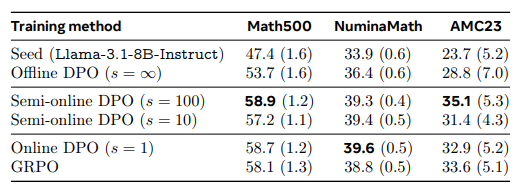

Additionally, [Tong et al. 2025](https://arxiv.org/html/2505.17017v2#:~:text=DPO%20demonstrates%20stronger%20performance%20than,by%20an%20average%20of%2011.53%25) show that DPO outperforms GRPO on in-domain tasks, while GRPO performs better on out-of-distribution data. This observation was expected, since GRPO uses online sampling and hence, generalizes better.

<hr style="border:10px solid red"> </hr>

In Christiano et al., 2017, the authors propose a formula for modeling pairwise preference:
$$
{\pi}_\phi(y_w \succ y_l \mid x) = \frac{\exp r_\phi(x, y_w)}{\exp r_\phi(x, y_w) + \exp r_\phi(x, y_l)},$$
where $r_\phi(x, y_w)$ and $r_\phi(x, y_l)$ are scores assigned to winner and loser, respectively.

[Ziegler et al., 2019](https://arxiv.org/pdf/1909.08593) build on of Christiano et al., 2017 and derive an KL-objective for maximizing the reward while not deviating far from the reference policy. This is written as follows:
$$
\max_{\pi}\; \mathbb{E}_{x,y\sim \pi(\cdot|x)}[\,r(x,y)\,]
\;-\; \beta\,\mathbb{E}_{x}\!\left[\,\mathrm{KL}\!\left(\pi(\cdot|x)\,\|\,\pi_{\text{ref}}(\cdot|x)\right)\right]. $$
DPO uses KL term as the difference between log probabilities of current and reference policy, so the previous equation becomes:
$$
\max_{\pi}\; \mathbb{E}_{x,y\sim\pi(\cdot|x)}\!\left[r(x,y)\;-\;\beta \log \frac{\pi(y\mid x)}{\pi_{\text{ref}}(y\mid x)}\right].
$$



[Rafailov et al., 2023](https://arxiv.org/pdf/2305.18290) show *(Appendix A.1)* that the optimal solution to this maximization objective is the policy:
$$
\pi^*(y|x)
= \frac{1}{Z(x)}\,\pi_{\text{ref}}(y|x)\exp\!\left(\tfrac{1}{\beta}\,r(x,y)\right),
$$
where $Z(x)$ is a partition function that gets canceled in further equations. This is the approximation of current policy. Now, by taking the logarithm of both sides from the previous equation, the optimal reward is obtained:
$$
r(x,y)
= \beta \log\frac{\pi^*(y|x)}{\pi_{\text{ref}}(y|x)}
+ \beta \log Z(x).
$$
By putting the last equation into the first:
$$
p^*(y_w \succ y_l \mid x)
= \frac{\exp\!\left(\beta \log \frac{\pi^*(y_w\mid x)}{\pi_{\text{ref}}(y_w\mid x)} + \beta \log Z(x)\right)}
{\exp\!\left(\beta \log \frac{\pi^*(y_w\mid x)}{\pi_{\text{ref}}(y_w\mid x)} + \beta \log Z(x)\right)
+ \exp\!\left(\beta \log \frac{\pi^*(y_l\mid x)}{\pi_{\text{ref}}(y_l\mid x)} + \beta \log Z(x)\right)}
$$

$$
= \frac{1}{1 + \exp\!\left(\beta \log \frac{\pi^*(y_l\mid x)}{\pi_{\text{ref}}(y_l\mid x)}
- \beta \log \frac{\pi^*(y_w\mid x)}{\pi_{\text{ref}}(y_w\mid x)}\right)}
$$

$$
= \sigma\!\left(
\beta \log \frac{\pi^*(y_w\mid x)}{\pi_{\text{ref}}(y_w\mid x)}
- \beta \log \frac{\pi^*(y_l\mid x)}{\pi_{\text{ref}}(y_l\mid x)}
\right),
$$
which actually represents the DPO instance-loss. Final DPO's objective is computed as follows: $$
\mathcal{L}_{\mathrm{DPO}}(\pi_\theta;\pi_{\mathrm{ref}})
= -\,\mathbb{E}_{(x,y_w,y_l)\sim\mathcal{D}}
\Big[
\log \sigma\!\Big(
\beta \log \tfrac{\pi_\theta(y_w\mid x)}{\pi_{\mathrm{ref}}(y_w\mid x)}
- \beta \log \tfrac{\pi_\theta(y_l\mid x)}{\pi_{\mathrm{ref}}(y_l\mid x)}
\Big)
\Big].
$$
On the other hand, the GRPO approximates KL-regularized objective using group-relative advantages and explicit KL term ([Shout et al. 2024](https://arxiv.org/pdf/2402.03300)):

$$
\mathcal{L}_{\mathrm{GRPO}}(\theta)
= \mathbb{E}_{x,\{y_i\}\sim \pi_{\text{old}}(\cdot|x)}
\!\left[
\frac{1}{G}\sum_{i=1}^{G}\Big(\,\hat A_i(\theta)\;-\;\beta\,D_{\mathrm{KL}}\!\big[\pi_\theta \,\|\, \pi_{\mathrm{ref}}\big])
\right],
$$
where
$$
\hat A_i(\theta)=\min\!\left\{\frac{\pi_\theta(y_i\mid x)}{\pi_{\text{old}}(y_i\mid x)}\,A_i,\;\mathrm{clip}(\frac{\pi_\theta(y_i\mid x)}{\pi_{\text{old}}(y_i\mid x)},1-\epsilon,1+\epsilon)\,A_i\right\},\quad
$$
$$
D_{\mathrm{KL}}\!\big[\pi_\theta(\cdot\mid x)\,\|\,\pi_{\text{ref}}(\cdot\mid x)\big]
=
\dfrac{\pi_{\text{ref}}(y\mid x)}{\pi_\theta(y\mid x)}
-\log\dfrac{\pi_{\text{ref}}(y\mid x)}{\pi_\theta(y\mid x)}
-1.
$$

For each question, GRPO takes a group of outputs $\{o_{1}, o_{2}, \ldots, o_{G}\}$ from the old policy $\pi_{\text{old}}$. $A_{i}$ represents the advantage corresponding to the output $o_{i}$ within the group, defined as:

$$
A_i = \frac{r_i - \mathrm{mean}(r_1, \ldots, r_G)}
{\mathrm{std}(r_1, \ldots, r_G)}.
$$
Reward values come from the reward model with a per-token KL penalty:
$$
r_t = r_\phi(q, o_{\le t}) - \beta \log
\frac{\pi_\theta(o_t \mid q, o_{<t})}
{\pi_{\mathrm{ref}}(o_t \mid q, o_{<t})}.
$$


<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 2: </b><br>

- Why can **reward model overfitting** or **reward hacking** occur in reinforcement fine-tuning?  
- How do DPO and GRPO attempt to mitigate this without explicit online reward models?  
- Discuss the role of the **reference model** in maintaining stability.
<hr style="border:10px solid red"> </hr>
</font></h4>

<b><h4><font color='green'>
<hr style="border:10px solid red"> </hr>
Answer 2: </b><br>

<hr style="border:10px solid red"> </hr>
</font></h4>

Reward hacking is a phenomenon in which an agent (model) exploits errors in the reward model and finds a way to maximize its rewards without actually completing the intended task ([Liu et al. 2025](https://arxiv.org/html/2510.01925v1#S5), [Eisenstein et al. 2023](https://arxiv.org/pdf/2312.09244)). There are several ways this problem can occur:
- Poor reward functions ([Fu et al. 2025](https://arxiv.org/pdf/2502.18770)): Simple, non-continuous or poorly shaped reward functions (e.g. unbounded, not centered) allow the model to find an easy shortcut to flaws.
- Outcome supervision only ([Lightman et al., 2023](https://arxiv.org/pdf/2305.20050)): When the reward model only supervises the final output, policy recieves no feedback on intermediate steps. Consequently, it aims for maximizing the reward rather than improving its reasoning which can often lead to reward hacking or over-optimization.
- Coupled reward signals ([Chen et al. 2024](https://proceedings.mlr.press/v235/chen24bn.html)): Having shared reward for answer length and its accuracy can result in model exploAting high reward by producing longer but low-quality results. More generally, coupling unrelated attributes through the reward can result in model inflation on one attribute to mask the deficits in the other.
- In-context learning ([Pan et al. 2022](https://openreview.net/forum?id=JYtwGwIL7ye)): Hacking can also happen during inference. A model can adapt its output through context and feedback loops (self-reflection) by exploating the rewards at deployment time. In these cases, the model can increase its reward but decrease the correctness and diversity.
- Incomplete objective ([Pan et al. 2022](https://openreview.net/forum?id=JYtwGwIL7ye)): Ambiguous goal definitions and incomplete feedback can overlook implicit constraints which can lead to unintended side effects.
- Reward misspecification ([Pan et al. 2022](https://openreview.net/forum?id=JYtwGwIL7ye); [Lambert et al. 2024](https://arxiv.org/pdf/2403.13787)): The reward model trained from human preference data only approximates true human values, which can result in optimization of the reward model that does not always optimize true human intent.
- Human feedback ([Wen et al., 2024](https://arxiv.org/pdf/2409.12822)): The model aims to align with human preferences, but sometimes, human feedback may not capture all the aspects we care about (e.g. factuality) and thus can be hacked to overfit to undesired attributes. In other words, a gap between what is correct and what looks correct to humans can cause reward hacking.

<hr style="border:10px solid red"> </hr>

We note that DPO doesn't exhibit the same reward hacking as GRPO since it doesn't use an explicit reward model. However, it can still be prone to some related, one of which is to develop a biased distribution toward unseen and undesirable results ([Xu et al., 2024](https://arxiv.org/pdf/2404.10719)).

In case of GRPO, [Ichihara et al., 2025](https://arxiv.org/pdf/2509.22047) show that one of the possible solutions to reward hacking is the normalization of the reward functions according to their variances.

A universal mitigation mechanism used by both algorithms is proximity regularization ([Jinnai et al., 2024](https://arxiv.org/html/2404.01054v3)). The regularization ensures that the trained model remains close to the reference model from which we initialize. In practice, both DPO and GRPO implement regularization through KL divergence which compares probability distributions of the current and initial response. The KL term is scaled by the hyperparameter $β$ which controls the clossenes to the reference model-e.g. higher $β$ values keep the model closer, while lower ones allow more exploration and can often lead to out-of-distribution responses.

Overall, the reference model plays a key role as a keeper of the base distribution. It provides the responses from which the current model shouldn't to deviate too far and thus keeps algorithms stable and more robust to reward hacking and similar phenomena.


<b><h4><font color='red'>
<hr style="border:10px solid red"> </hr>
Question 3: </b><br>

- In the GSM8K setup, we used a simple binary reward for **format** and **correctness**.  
  - What are the limitations of such sparse rewards?  
  - How could you design a **richer, smoother** reward signal for math reasoning?
<hr style="border:10px solid red"> </hr>
</font></h4>

<b><h4><font color='green'>
<hr style="border:10px solid red"> </hr>
Answer 3: </b><br>

<hr style="border:10px solid red"> </hr>
</font></h4>

The limitations of these rewards are as follows:
- The learning is limited because of all-or-nothing supervision. The model has no feedback on intermediate steps and aims for maximizing the reward rather than improving its reasoning. This can often lead to reward hacking or over-optimization. ([Lightman et al., 2023](https://arxiv.org/pdf/2305.20050))
- Models trained with these rewards often use incorrect reasoning to reach the correct final answer ([Zelikman et al., 2022](https://arxiv.org/pdf/2203.14465); [Creswell et al., 2022](https://arxiv.org/pdf/2205.09712)), resulting in high proportion of false positives. ([Lightman et al., 2023](https://arxiv.org/pdf/2305.20050))
- Partially correct or alternative answers are under-creditted by verifiers, resulting in high proportion of false negatives. ([Tao et al., 2025](https://arxiv.org/html/2510.07242v1#bib.bib21))
- The model fails to generalize well since non-continuous rewards don't indicate where an incorrect solution went wrong. ([Lightman et al., 2023](https://arxiv.org/pdf/2305.20050))
- The model tends to skew the optimization toward easier cases which leaves the most informative prompts  underutilized. ([Tao et al., 2025](https://arxiv.org/html/2510.07242v1#bib.bib21))
- The model may learn to optimize only one objective (e.g. formatting since it's easier) and mask the other, resulting in learning stagnation.
- Specifically for GRPO, if all rolouts recieve the same label (e.g., all 1s), the relative advantage over groups is zero, resulting in no useful policy gradient.

<hr style="border:10px solid red"> </hr>

In order to obtain richer feedback, we should use reward models. Among them, process-supervised reward models (PRMs) have demonstrated clear advantages on math reasoning tasks ([Lightman et al., 2023](https://arxiv.org/pdf/2305.20050) and [Wang et al., 2023b](https://arxiv.org/pdf/2312.08935)).

In their work, authors compare outcome reward models (ORMs) with PRMs. ORMs evaluate only the final result (as in our lab), while PRMs evaluate each reasoning step.

Each step in the training of PRMs is assigned a label (e.g., 'good', 'bad' and/or 'neutral'), and the scores are optimized with cross-entropy loss. During inference, the final score is computed as a minimum or a product over step-level scores.

Compared with ORMs, PRMs provide much more detailed and reliable feedback (Lightman et al., 2023). Experimental results from Wang et al., 2023 further prove that PRMs significantly outperform ORMs (image below). This setup helps policies learn from partially correct reasoning paths and better assign score over diverse solutions (Lightman et al., 2023). Therefore, for a richer reward signal in math reasoning, we should opt for a reward model based on process supervision.

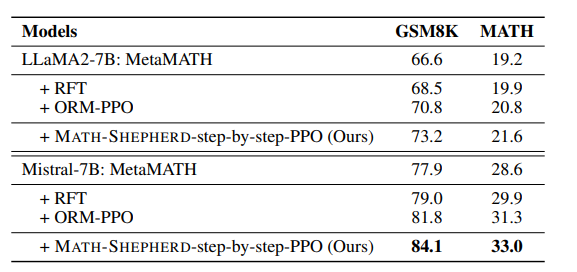